In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=10,6

C:\Users\Ramana Reddy (Rakhi)\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset=pd.read_excel(r"C:\Users\Ramana Reddy (Rakhi)\OneDrive\Desktop\crypto project\makar coin.xlsx")
dataset

,ticker,date,open,high,low,close
0,MKR,2018-01-01,1005.75,1051.12,945.25,1020.87
1,MKR,2018-01-02,1180.90,1189.52,1017.12,1034.36
2,MKR,2018-01-03,1129.32,1298.72,1082.26,1082.26
3,MKR,2018-01-04,1086.55,1171.59,944.83,944.83
4,MKR,2018-01-05,1063.84,1083.19,967.13,1015.49
...,...,...,...,...,...,...
2366,MKR,2024-06-26,2373.94,2498.94,2326.68,2464.30
2367,MKR,2024-06-27,2464.06,2671.10,2443.23,2604.31
2368,MKR,2024-06-28,2605.58,2652.80,2506.90,2514.27
2369,MKR,2024-06-29,2514.13,2564.56,2439.21,2445.96


In [3]:
dataset['date']=pd.to_datetime(dataset['date'],infer_datetime_format=True)
indexedDataset= dataset.set_index(['date'])

In [4]:
indexedDataset=indexedDataset.drop(columns=['ticker','high','low','open'])
indexedDataset=indexedDataset.resample('M').mean()
indexedDataset.head()

,close
date,
2018-01-31,1334.022903
2018-02-28,1049.401429
2018-03-31,755.361935
2018-04-30,735.734000
2018-05-31,923.799677


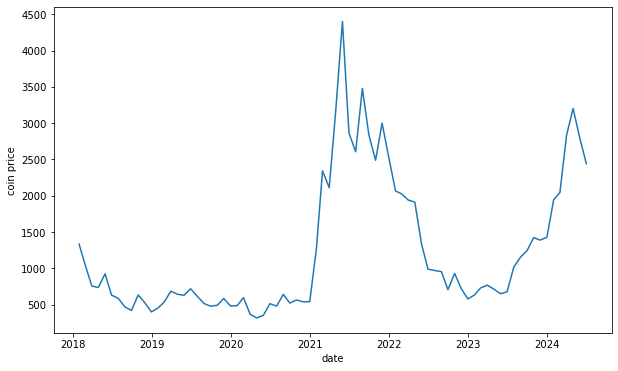

In [5]:
plt.xlabel('date')
plt.ylabel('coin price')
plt.plot(indexedDataset)

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #determing rolling statistics
    moving_avg=timeseries.rolling(window=12).mean()
    moving_std = timeseries.rolling(window=12).std()
    
    #plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(moving_avg,color='red',label='rolling mean' )
    std=plt.plot(moving_std,color='black',label='rolling std')
    plt.legend(loc='best')
    plt.show(block=False)
    #perform Dickey fuller test;
    print("results of Dickey-fuller test:")
    dftest=adfuller(timeseries['close'],autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test statistic','p-value','lags used','number of Observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key]=value
    print(dfoutput)

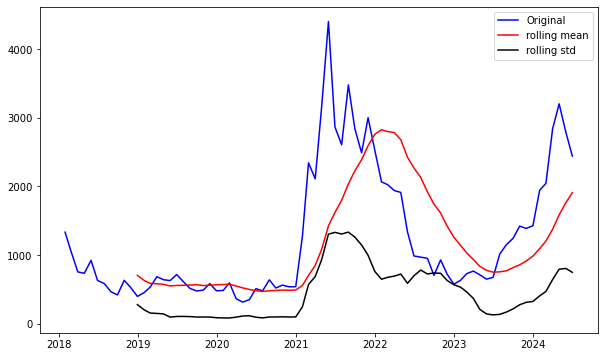

results of Dickey-fuller test:
Test statistic                 -2.535062
p-value                         0.107175
lags used                       3.000000
number of Observations used    74.000000
Critical value (1%)            -3.521980
Critical value (5%)            -2.901470
Critical value (10%)           -2.588072
dtype: float64


In [7]:
test_stationarity(indexedDataset)

In [27]:
#estimating trend
#indexedDataset_shift=indexedDataset.shift(12).dropna()
#plt.plot(indexedDataset_shift)
#test_stationarity(indexedDataset_shift)

In [29]:
#indexedDataset_logscale=np.log(indexedDataset_shift)
#test_stationarity(indexedDataset_logscale)

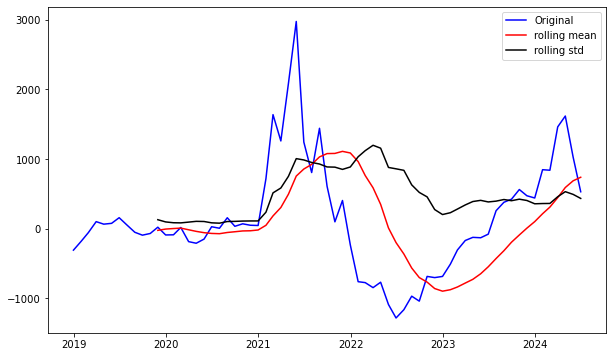

results of Dickey-fuller test:
Test statistic                 -3.005749
p-value                         0.034361
lags used                       3.000000
number of Observations used    63.000000
Critical value (1%)            -3.538695
Critical value (5%)            -2.908645
Critical value (10%)           -2.591897
dtype: float64


In [11]:
moving_avg=indexedDataset.rolling(window=12).mean()
datasetlogscale_moving_avg=indexedDataset-moving_avg
datasetlogscale_moving_avg.head(12)
#remove nan values
datasetlogscale_moving_avg.dropna(inplace=True)
test_stationarity(datasetlogscale_moving_avg)

# Seasonal Decompose

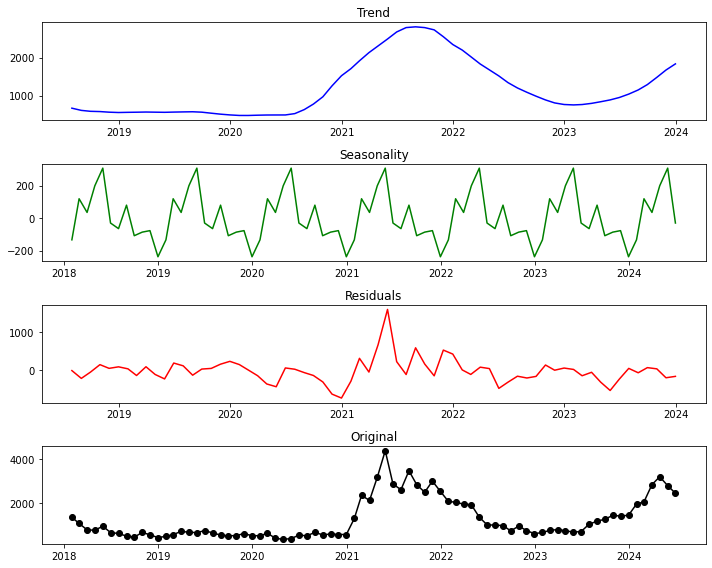

In [12]:
decomposition = seasonal_decompose(indexedDataset, model='additive')
plt.figure(figsize=(10,8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.title('Trend')

plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonality')

plt.subplot(4, 1, 3)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Residuals')

plt.subplot(4, 1, 4)
plt.plot(indexedDataset.index,indexedDataset.values, marker='o', linestyle='-', label='Original', color='black')
plt.title('Original')

plt.tight_layout()
plt.show()

# AUTO CORRELATION AND PARTIAL AUTOCORRELATION graphs

C:\Users\Ramana Reddy (Rakhi)\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


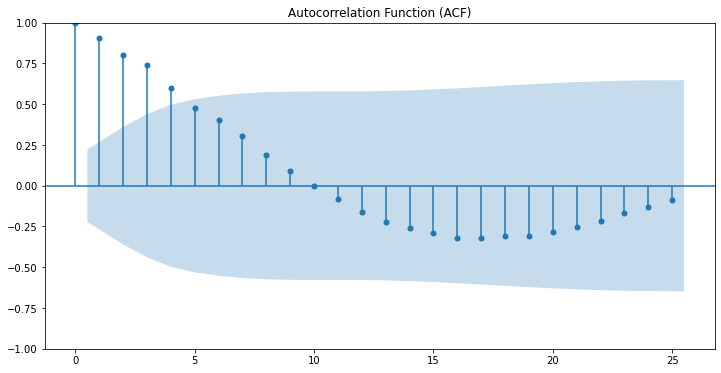

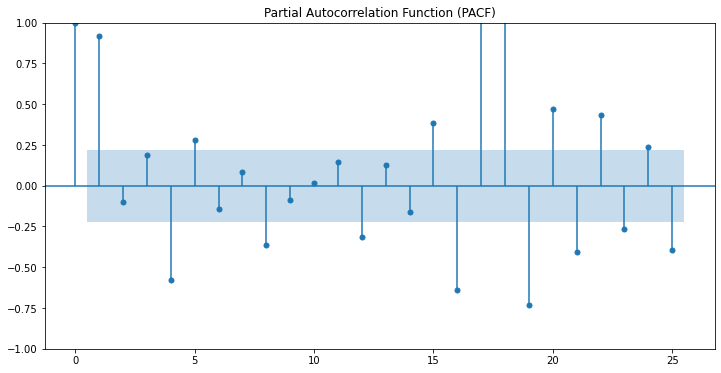

In [31]:
import statsmodels.api as sm

# Plot ACF
fig, ax1 = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(indexedDataset['close'], lags=25, ax=ax1)
plt.title('Autocorrelation Function (ACF)')

# Plot PACF
fig, ax2 = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(indexedDataset['close'], lags=25, ax=ax2)
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

In [14]:
# Split data into train and test sets
X = np.arange(len(indexedDataset)).reshape(-1, 1)
y = indexedDataset.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(62, 1)
(62, 1)
(16, 1)
(16, 1)


C:\Users\Ramana Reddy (Rakhi)\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   62
Model:                 ARIMA(4, 0, 9)   Log Likelihood                -442.764
Date:                Mon, 26 Aug 2024   AIC                            915.528
Time:                        19:25:20   BIC                            947.436
Sample:                             0   HQIC                           928.056
                                 - 62                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1142.0892    781.732      1.461      0.144    -390.078    2674.257
ar.L1          2.0992      4.709      0.446      0.656      -7.129      11.328
ar.L2         -1.1429      7.271     -0.157      0.875     -15.393      13.107
ar.L3         -0.0899      4.003     -0.022      0.982      -7.935       7.756
ar.L4          0.1274      2.272      0.056      0.955      -4.326       4.581
ma.L1         -0.9316      4.733     -0.197      0.844     -10.209       8.346
ma.L2         -0.5397      2.578     -0.209      0.834      -5.593       4.513
ma.L3          0.9463      3.635      0.260      0.795      -6.179       8.072
ma.L4         -0.3998      2.536     -0.158      0.875      -5.370       4.570
ma.L5         -0.6445      1.361     -0.473      0.636      -3.312       2.023
ma.L6          0.9072      3.235      0.280      0.779      -5.433       7.247
ma.L7         -0.1315      2.314     -0.057      0.955      -4.667       4.404
ma.L8         -0.4968      1.544     -0.322      0.748      -3.523       2.530
ma.L9          0.3114      1.966      0.158      0.874      -3.543       4.165
sigma2      1.338e+05   6.57e+04      2.038      0.042    5112.883    2.63e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                52.93
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             1.10
Prob(H) (two-sided):                  0.11   Kurtosis:                         6.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.2e+14. Standard errors may be unstable.
"""

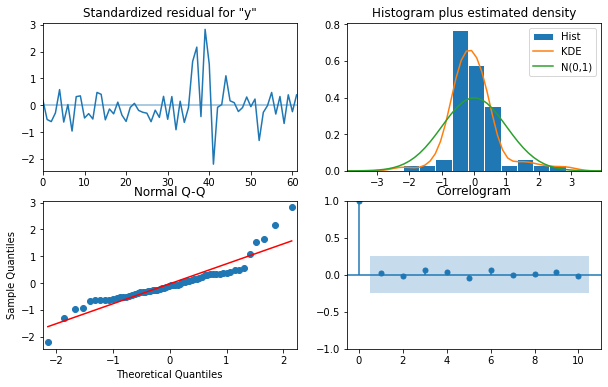

In [32]:
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit ARIMA model
arima_model = ARIMA(y_train,order=(4,0,9))
pred_arima = arima_model.fit()
predicion=pred_arima.plot_diagnostics()
pred_arima.summary()

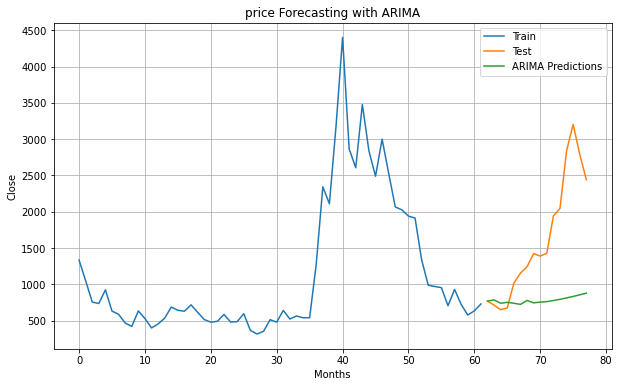

In [33]:
arima_predictions =pred_arima.forecast(steps=len(X_test))
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, label='Train')
plt.plot(X_test, y_test, label='Test')
plt.plot(X_test, arima_predictions, label='ARIMA Predictions')
plt.title('price Forecasting with ARIMA')
plt.xlabel('Months')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
index_future_date=pd.date_range(start='2024-06-30',end='2024-09-25')
print(index_future_date)
pred=pred_arima.predict(start=len(indexedDataset),end=len(indexedDataset)+50,typ='levels')
#print(comp_pred)
predindex=index_future_date
dataframe=pd.DataFrame(pred)
dataframe.head(10)

DatetimeIndex(['2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
               '2024-07-28', '2024-07-29', '2024-07-30', '2024-07-31',
               '2024-08-01', '2024-08-02', '2024-08-03', '2024-08-04',
               '2024-08-05', '2024-08-06', '2024-08-07', '2024-08-08',
               '2024-08-09', '2024-08-10', '2024-08-11', '2024-08-12',
               '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16',
               '2024-08-17', '2024-08-18', '2024-08-19', '2024-08-20',
               '2024-08-21', '2024-08-22', '2024-08-23', '2024-08-24',
      

,0
0,901.574138
1,925.457052
2,949.402312
3,973.179321
4,996.579396
5,1019.415015
6,1041.519599
7,1062.747173
8,1082.971974
9,1102.087921


<AxesSubplot:>

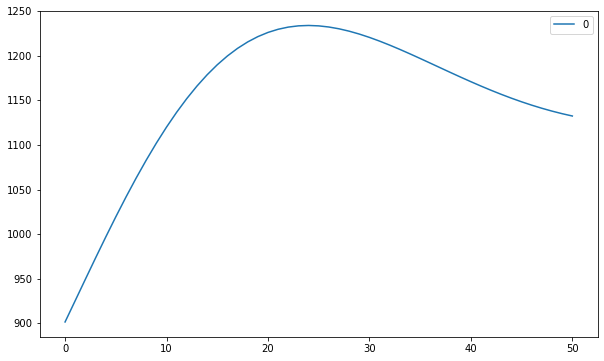

In [35]:
dataframe.plot()

In [36]:
print(mean_absolute_error(y_test,arima_predictions))
print(mean_squared_error(y_test,arima_predictions))
print(r2_score(y_test,arima_predictions))

856.5650127988357
1290847.402176215
-0.9561084193302272
